In [112]:
from google.colab import drive

drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [113]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet, stopwords
from nltk import word_tokenize, pos_tag
import re
import matplotlib.pyplot as plt
import json
import datetime, time
import pytz
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [114]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')

PATS = 0
HAWKS = 1

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Clean, lemmatize data and extract relevant features as Dataframe

In [115]:
import string

def clean(text):
    # Remove URLs
    cleaned_text = re.sub(r"http\S+", "", text)
    # Remove hashtags
    cleaned_text = re.sub(r"#\S+", "", cleaned_text)
    # Remove mentions
    cleaned_text = re.sub(r"@\S+", "", cleaned_text)
    # Remove emoticons
    cleaned_text = re.sub(r":[^:\s]*(?:::[^:\s]*)*:", "", cleaned_text)
    # Remove numbers
    cleaned_text = re.sub(r"\b\d+\b", "", cleaned_text)
    # Remove punctuation and convert to lowercase
    cleaned_text = re.sub(r"[^\w\s]", "", cleaned_text).lower()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    cleaned_text = " ".join(word for word in cleaned_text.split() if word not in stop_words)
    return cleaned_text

def get_pos(tag):  # get the property of a word from the pos_tag results
    if tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatization(text):
    wnl = WordNetLemmatizer()
    words = word_tokenize(text)  # divide the words of each data point
    tags = pos_tag(words)  # return the property of each word
    lemma = []
    for tag in tags:
        pos = get_pos(tag[1])
        lemma.append(wnl.lemmatize(tag[0], pos).lower())  # do the lemmatization
    return ' '.join(lemma)

def clean_and_lemmatize(tweet):
  tweet = clean(tweet)
  tweet = lemmatization(tweet)
  return tweet

In [116]:
def extract_tweet_data_part_2(pats_filename, hawks_filename):
  num_non_tweet =  0
  num_non_english = 0
  num_non_text = 0
  num_non_timestamp = 0
  num_non_follows = 0
  num_non_likes = 0

  # features required: tweet text, user follower count, timestamp, team (fanbase)
  # target: number of likes
  df = pd.DataFrame(columns = ['Text', 'Follows', 'Timestamp', 'Team', 'Likes'])

  with open(pats_filename, encoding = "UTF-8") as file:
    while True:
      tweet = file.readline()
        
      # reached end of file
      if not tweet:
        num_non_tweet += 1
        break
        
      tweet_json = json.loads(tweet)

      if (tweet_json['tweet']['lang'] != 'en'):
        num_non_english += 1
        continue

      tweet_text = clean_and_lemmatize(tweet_json['tweet']['text'])
      tweet_timestamp = tweet_json['citation_date']        
      user_follow_count = tweet_json['author']['followers']
      num_likes = tweet_json['tweet']['favorite_count']

      if not tweet_text:
        num_non_text += 1
        continue;
      if not tweet_timestamp:
        num_non_timestamp += 1
        continue;
      if user_follow_count is None:
        num_non_follows += 1
        continue;
      if num_likes is None:
        num_non_likes += 1
        continue;

      df = df.append({'Text': tweet_text, 'Follows': user_follow_count, 'Timestamp': tweet_timestamp, 'Team': PATS, 'Likes': num_likes}, ignore_index = True)
  
  with open(hawks_filename, encoding = "UTF-8") as file:
    while True:
      tweet = file.readline()
        
      # reached end of file
      if not tweet:
        num_non_tweet += 1
        break
        
      tweet_json = json.loads(tweet)

      if (tweet_json['tweet']['lang'] != 'en'):
        num_non_english += 1
        continue

      tweet_text = clean_and_lemmatize(tweet_json['tweet']['text'])
      tweet_timestamp = tweet_json['citation_date']        
      user_follow_count = tweet_json['author']['followers']
      num_likes = tweet_json['tweet']['favorite_count']

      if not tweet_text:
        num_non_text += 1
        continue;
      if not tweet_timestamp:
        num_non_timestamp += 1
        continue;
      if user_follow_count is None:
        num_non_follows += 1
        continue;
      if num_likes is None:
        num_non_likes += 1
        continue;

      df = df.append({'Text': tweet_text, 'Follows': user_follow_count, 'Timestamp': tweet_timestamp, 'Team': HAWKS, 'Likes': num_likes}, ignore_index = True)

  print(num_non_tweet)
  print(num_non_english)
  print(num_non_text)
  print(num_non_timestamp)
  print(num_non_follows)
  print(num_non_likes)
  return df

In [117]:
df = extract_tweet_data_part_2('drive/MyDrive/Twitter/tweets_#gopatriots.txt', 'drive/MyDrive/Twitter/tweets_#gohawks.txt')

2
37382
1066
0
0
0


In [118]:
print(df)

                                                     Text  Follows  \
0       legarrette blount ray lewis dance hope see lea...   2895.0   
1                    father husband yell tv hard get game  20896.0   
2           girl soccer team rank team state full ranking    500.0   
3                               patriot champion rt agree    491.0   
4       girl varsity soccer team dominate first playof...    500.0   
...                                                   ...      ...   
154180                      long think go back super bowl    120.0   
154181                                       day everyday     47.0   
154182      interview seattle seahawks superbowl champion   1496.0   
154183                      love russell wilson want know    120.0   
154184  ultimate broken hearted hangover week hell alm...    358.0   

         Timestamp Team Likes  
0       1421257541    0     0  
1       1421341875    0     0  
2       1421285189    0     1  
3       1421427332    0     0  

In [119]:
# save for future use, to not rerun extraction again
from google.colab import files

df.to_csv('df_part_2.csv', encoding = "UTF-8")
files.download('df_part_2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
likes = df['Likes'].unique()
print(sorted(likes))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 31, 32, 34, 35, 38, 40, 41, 43, 44, 46, 47, 49, 52, 55, 56, 58, 60, 61, 62, 66, 69, 77, 79, 83, 91, 109, 127, 135, 142, 151, 164, 166, 176, 284, 326, 356, 382, 392, 526, 568, 592, 758, 3667, 6087, 42738]


## Model 1 (Using timestamp, follows, and tweet content to predict number of likes)

### Pre-processing (normalization, TF-IDF, SVD) on Dataframe

In [ ]:
df = pd.read_csv('df_part_2.csv', encoding = "UTF-8")

In [120]:
df1 = df

In [121]:
# randomize data as train_test_split will only pick last N datapoints as testing set
df1 = df1.sample(frac=1, random_state=42).reset_index(drop=True)

In [122]:
df1.dropna(inplace=True)

In [123]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

# split into train and test data
df_train, df_test = train_test_split(df1, test_size=0.25, random_state = 42)

# convert text into TFIDF vectors, reduced to 50 components using SVD
text_vec_pipeline = Pipeline([('convector', CountVectorizer(stop_words='english', min_df=3)), ('tfidf', TfidfTransformer()), ('dim_reduce', TruncatedSVD(50, random_state=42))])

df_train['TFIDF'] = text_vec_pipeline.fit_transform(df_train['Text']).tolist()
df_test['TFIDF'] = text_vec_pipeline.transform(df_test['Text']).tolist()

In [124]:
print(df_train['TFIDF'])

83935     [0.08265782385402726, 0.038876548279218964, 0....
36036     [0.26093617354068466, -0.2200419618583431, -0....
65360     [0.29155978646491915, 0.301121578130627, 0.154...
102223    [6.977940559528282e-05, -1.0988529099719303e-0...
116326    [0.2137355016578547, -0.08028334707650589, -0....
                                ...                        
119879    [0.01582536454121186, -0.0023933750017854135, ...
103694    [0.01572323082811718, 0.00038825127970549286, ...
131932    [0.05281261532320775, 0.007862118400044617, 0....
146867    [0.00960428629542284, 0.0035305183971040418, 0...
121958    [0.018024621318541108, -0.00332755243026561, -...
Name: TFIDF, Length: 115638, dtype: object


In [125]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_train[['Timestamp','Likes','Follows']] = scaler.fit_transform(df_train[['Timestamp','Likes','Follows']])
df_test[['Timestamp','Likes','Follows']] = scaler.transform(df_test[['Timestamp','Likes','Follows']])

### Extracting X and Y

In [126]:
X_train = np.stack(df_train.apply(lambda row: np.concatenate([row['TFIDF'], [row['Timestamp'], row['Follows']]]), axis=1))
y_train = df_train[['Likes']].values.ravel()

X_test = np.stack(df_test.apply(lambda row: np.concatenate([row['TFIDF'], [row['Timestamp'], row['Follows']]]), axis=1))
y_test = df_test[['Likes']].values.ravel()

In [127]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(115638, 52)
(115638,)
(38547, 52)
(38547,)


In [128]:
print(X_train)

[[ 8.26578239e-02  3.88765483e-02  4.86241487e-02 ... -6.00653285e-03
   1.97775448e-01  2.96490631e-06]
 [ 2.60936174e-01 -2.20041962e-01 -1.05506977e-01 ...  2.52922190e-03
   1.90936439e-01  2.13896812e-05]
 [ 2.91559786e-01  3.01121578e-01  1.54765964e-01 ...  6.43132592e-03
   7.72283949e-01  8.89471893e-06]
 ...
 [ 5.28126153e-02  7.86211840e-03  1.84896686e-02 ...  5.16522056e-03
   6.87191221e-01  3.36728645e-05]
 [ 9.60428630e-03  3.53051840e-03  1.79757041e-03 ... -2.59331215e-02
   7.70696218e-01  9.12767585e-05]
 [ 1.80246213e-02 -3.32755243e-03 -8.66150959e-04 ...  7.84247448e-02
   2.59389947e-01  1.10125092e-05]]


### Random Forest Regressor

In [129]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Create a random forest regression model
rf = RandomForestRegressor(n_estimators=100, random_state=42, verbose=2, n_jobs = -1)

# Train the model on X_train and y_train
rf.fit(X_train, y_train)

# Evaluate model on X_test and y_test
mse = mean_squared_error(y_test, rf.predict(X_test))
print(mse)

# R2 coefficient
rf.score(X_test, y_test)

building tree 1 of 100building tree 2 of 100
building tree 3 of 100
building tree 4 of 100



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.1min


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s


6.643779077238738e-07


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished


-0.24846702853802305

### Gradient Boosting Regressor

In [130]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Create a gradient boosting regression model
gb = GradientBoostingRegressor(n_estimators=100, random_state=42, verbose=2)

# Train the model on X_train and y_train
gb.fit(X_train, y_train)

# Evaluate model on X_test and y_test
mse = mean_squared_error(y_test, gb.predict(X_test))
print(mse)

# R2 coefficient
gb.score(X_test, y_test)

      Iter       Train Loss   Remaining Time 
         1           0.0000            4.62m
         2           0.0000            4.54m
         3           0.0000            4.49m
         4           0.0000            4.44m
         5           0.0000            4.41m
         6           0.0000            4.37m
         7           0.0000            4.32m
         8           0.0000            4.27m
         9           0.0000            4.22m
        10           0.0000            4.17m
        11           0.0000            4.13m
        12           0.0000            4.08m
        13           0.0000            4.04m
        14           0.0000            3.99m
        15           0.0000            3.94m
        16           0.0000            3.89m
        17           0.0000            3.85m
        18           0.0000            3.81m
        19           0.0000            3.76m
        20           0.0000            3.71m
        21           0.0000            3.67m
        2

-0.042700924565096

## Model 2 (Using timestamp, follows, tweet content, tweet sentiment, and fanbase sentiment to predict number of likes)

### Pre-processing (normalization, TF-IDF, SVD, Average Sentiment analysis) on Dataframe

In [ ]:
df = pd.read_csv('df_part_2.csv', encoding = "UTF-8")

In [131]:
df2 = df

In [132]:
# randomize data as train_test_split will only pick last N datapoints as testing set
df2 = df2.sample(frac=1, random_state=42).reset_index(drop=True)

In [133]:
# drop any NAs caused by saving as CSV
df2.dropna(inplace=True)

# split into train and test data
df_train, df_test = train_test_split(df2, test_size=0.25, random_state = 42)

In [134]:
print(df_train)

                                                     Text  Follows  \
83935                                     go patriot come     14.0   
36036                                           game kill    101.0   
65360             fan watch super bowl let keep eye crowd     42.0   
102223                                       superstition    183.0   
116326      happy blue friday cant wait cheer game sunday    495.0   
...                                                   ...      ...   
119879                                             thanks  10330.0   
103694  save tee amp merch dont ever pay full price shirt   2508.0   
131932  know im delirious flt delay try get didnt see ...    159.0   
146867                            prediction mvp go lynch    431.0   
121958                                            awesome     52.0   

         Timestamp Team Likes  
83935   1421634368    0     0  
36036   1421620132    1     0  
65360   1422830258    1     0  
102223  1422844150    0     0  

In [135]:
# VADER (Valence Aware Dictionary and sEntiment Reasoner) is known to work well with social media data such as Twitter
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download VADER resources
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Get tweet sentiment using content
def get_tweet_sentiment(tweet):
    score = analyzer.polarity_scores(tweet)
    return score['compound']

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [136]:
# Calculate the sentiment score for each tweet in the dataset
df_train['Sentiment'] = df_train['Text'].apply(get_tweet_sentiment)
df_test['Sentiment'] = df_test['Text'].apply(get_tweet_sentiment)

# We use train and test data separately, as we don't want to know about test data when building model

# Calculate average sentiment of the user's fanbase in the hour of tweeting
# Convert to date-time for easy grouping
df_train['Timestamp_DT'] = pd.to_datetime(df_train['Timestamp'], unit='s')
df_test['Timestamp_DT'] = pd.to_datetime(df_test['Timestamp'], unit='s')

In [137]:
print(df_train)

                                                     Text  Follows  \
83935                                     go patriot come     14.0   
36036                                           game kill    101.0   
65360             fan watch super bowl let keep eye crowd     42.0   
102223                                       superstition    183.0   
116326      happy blue friday cant wait cheer game sunday    495.0   
...                                                   ...      ...   
119879                                             thanks  10330.0   
103694  save tee amp merch dont ever pay full price shirt   2508.0   
131932  know im delirious flt delay try get didnt see ...    159.0   
146867                            prediction mvp go lynch    431.0   
121958                                            awesome     52.0   

         Timestamp Team Likes  Sentiment        Timestamp_DT  
83935   1421634368    0     0     0.0000 2015-01-19 02:26:08  
36036   1421620132    1     0    

In [138]:
from datetime import datetime

# Get average sentiment of Tweets in the hour of posting per fanbase
team_hourly_sentiment_train = df_train.groupby(['Team', pd.Grouper(key='Timestamp_DT', freq='H')])['Sentiment'].mean()
team_hourly_sentiment_test = df_test.groupby(['Team', pd.Grouper(key='Timestamp_DT', freq='H')])['Sentiment'].mean()

# Write a function to extract average sentiment based on Team and Hour
def get_average_sentiment(team, timestamp, train=True):
  if train:
    query_data = team_hourly_sentiment_train
  else:
    query_data = team_hourly_sentiment_test
  
  # parse timestamp to get hour
  hour_str = timestamp.strftime('%Y-%m-%d %H:00:00')
  hour_dt = datetime.strptime(hour_str, '%Y-%m-%d %H:%M:%S')

  # query to return value
  return query_data[team][hour_dt]

# Query and add column
df_train['Fanbase_Sentiment'] = df_train.apply(lambda row: get_average_sentiment(row['Team'], row['Timestamp_DT']), axis = 1)
df_test['Fanbase_Sentiment'] = df_test.apply(lambda row: get_average_sentiment(row['Team'], row['Timestamp_DT'], train=False), axis = 1)

In [139]:
print(df_train['Sentiment'])
print(df_train['Fanbase_Sentiment'])

83935     0.0000
36036    -0.6908
65360     0.7351
102223    0.0000
116326    0.2495
           ...  
119879    0.4404
103694    0.5417
131932   -0.3182
146867    0.0000
121958    0.6249
Name: Sentiment, Length: 115638, dtype: float64
83935     0.163082
36036     0.100919
65360     0.210795
102223    0.090222
116326    0.277111
            ...   
119879    0.312732
103694    0.202281
131932    0.311108
146867    0.249630
121958    0.268152
Name: Fanbase_Sentiment, Length: 115638, dtype: float64


In [140]:
# save for future use, to not rerun extraction again
from google.colab import files

df_train.to_csv('df_part_2_augmented_train.csv', encoding = "UTF-8")
files.download('df_part_2_augmented_train.csv')

df_test.to_csv('df_part_2_augmented_test.csv', encoding = "UTF-8")
files.download('df_part_2_augmented_test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [141]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

# convert text into TFIDF vectors, reduced to 50 components using SVD
text_vec_pipeline = Pipeline([('convector', CountVectorizer(stop_words='english', min_df=3)), ('tfidf', TfidfTransformer()), ('dim_reduce', TruncatedSVD(50, random_state=42))])

df_train['TFIDF'] = text_vec_pipeline.fit_transform(df_train['Text']).tolist()
df_test['TFIDF'] = text_vec_pipeline.transform(df_test['Text']).tolist()

In [142]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = MinMaxScaler()
standard_scaler = StandardScaler()

df_train[['Timestamp','Likes','Follows']] = scaler.fit_transform(df_train[['Timestamp','Likes','Follows']])
df_test[['Timestamp','Likes','Follows']] = scaler.transform(df_test[['Timestamp','Likes','Follows']])

df_train[['Sentiment', 'Fanbase_Sentiment']] = standard_scaler.fit_transform(df_train[['Sentiment', 'Fanbase_Sentiment']])
df_test[['Sentiment', 'Fanbase_Sentiment']] = standard_scaler.transform(df_test[['Sentiment', 'Fanbase_Sentiment']])

### Extracting X and Y

In [143]:
X_train = np.stack(df_train.apply(lambda row: np.concatenate([row['TFIDF'], [row['Timestamp'], row['Follows'], row['Sentiment'], row['Fanbase_Sentiment']]]), axis=1))
y_train = df_train[['Likes']].values.ravel()

X_test = np.stack(df_test.apply(lambda row: np.concatenate([row['TFIDF'], [row['Timestamp'], row['Follows'], row['Sentiment'], row['Fanbase_Sentiment']]]), axis=1))
y_test = df_test[['Likes']].values.ravel()

In [144]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(115638, 54)
(115638,)
(38547, 54)
(38547,)


In [145]:
print(X_train)

[[ 8.26578239e-02  3.88765483e-02  4.86241487e-02 ...  2.96490631e-06
  -5.35985831e-01 -5.61903716e-01]
 [ 2.60936174e-01 -2.20041962e-01 -1.05506977e-01 ...  2.13896812e-05
  -2.35731668e+00 -1.43060782e+00]
 [ 2.91559786e-01  3.01121578e-01  1.54765964e-01 ...  8.89471893e-06
   1.40214432e+00  1.04867639e-01]
 ...
 [ 5.28126153e-02  7.86211840e-03  1.84896686e-02 ...  3.36728645e-05
  -1.37493701e+00  1.50671531e+00]
 [ 9.60428630e-03  3.53051840e-03  1.79757041e-03 ...  9.12767585e-05
  -5.35985831e-01  6.47577025e-01]
 [ 1.80246213e-02 -3.32755243e-03 -8.66150959e-04 ...  1.10125092e-05
   1.11159617e+00  9.06421341e-01]]


### Random Forest Regressor

In [146]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Create a random forest regression model
rf = RandomForestRegressor(n_estimators=100, random_state=42, verbose=2, n_jobs = -1)

# Train the model on X_train and y_train
rf.fit(X_train, y_train)

# Evaluate model on X_test and y_test
mse = mean_squared_error(y_test, rf.predict(X_test))
print(mse)

# R2 coefficient
rf.score(X_test, y_test)

building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.1min


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s


5.999761703515993e-07


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished


-0.127446379363658

In [151]:
rf.feature_importances_

array([9.65193148e-03, 2.12338660e-04, 2.67083823e-04, 9.68460207e-03,
       4.96443243e-03, 5.89079559e-03, 8.93811005e-03, 5.51222574e-03,
       2.82662778e-03, 2.45020120e-02, 1.61959193e-03, 3.65644184e-02,
       2.55254780e-03, 1.63959246e-04, 2.06563989e-03, 1.53907615e-02,
       1.74310092e-03, 1.95059671e-02, 5.24938692e-04, 8.73016396e-03,
       1.54318230e-02, 3.40839317e-02, 7.55800880e-03, 3.71997141e-02,
       1.27170591e-02, 2.64723593e-04, 2.15915327e-03, 1.05713350e-02,
       2.39733123e-02, 3.91454317e-04, 1.88726859e-02, 3.54623932e-02,
       2.43836780e-02, 7.53354663e-02, 1.43606474e-03, 1.06403196e-02,
       5.04221290e-02, 2.25414534e-04, 1.37926822e-02, 1.71673746e-02,
       1.79170258e-02, 8.41922103e-03, 2.01818600e-02, 4.89160711e-03,
       9.18527585e-03, 3.15948850e-04, 1.61320895e-02, 9.22054015e-03,
       9.79618873e-03, 1.32884175e-02, 3.04552036e-02, 2.60034171e-01,
       2.24432017e-03, 4.45181587e-02])

### Gradient Boosting Regressor

In [147]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Create a gradient boosting regression model
gb = GradientBoostingRegressor(n_estimators=100, random_state=42, verbose=2)

# Train the model on X_train and y_train
gb.fit(X_train, y_train)

# Evaluate model on X_test and y_test
mse = mean_squared_error(y_test, gb.predict(X_test))
print(mse)

# R2 coefficient
gb.score(X_test, y_test)

      Iter       Train Loss   Remaining Time 
         1           0.0000            4.65m
         2           0.0000            4.59m
         3           0.0000            4.53m
         4           0.0000            4.48m
         5           0.0000            4.45m
         6           0.0000            4.39m
         7           0.0000            4.34m
         8           0.0000            4.30m
         9           0.0000            4.25m
        10           0.0000            4.20m
        11           0.0000            4.15m
        12           0.0000            4.10m
        13           0.0000            4.05m
        14           0.0000            4.01m
        15           0.0000            3.96m
        16           0.0000            3.91m
        17           0.0000            3.87m
        18           0.0000            3.83m
        19           0.0000            3.78m
        20           0.0000            3.73m
        21           0.0000            3.68m
        2

-0.056284923758387784

In [152]:
gb.feature_importances_

array([1.41113503e-07, 2.96873045e-04, 2.08339202e-07, 2.43847793e-07,
       0.00000000e+00, 0.00000000e+00, 5.29955637e-06, 5.79167528e-07,
       1.98005459e-07, 3.77113134e-04, 0.00000000e+00, 6.23284857e-08,
       7.04694629e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.37580702e-06, 1.13317368e-07, 7.81056602e-07,
       5.23710871e-03, 1.14486290e-07, 0.00000000e+00, 9.13873692e-03,
       0.00000000e+00, 6.52360160e-07, 0.00000000e+00, 3.95113232e-08,
       2.55835075e-03, 0.00000000e+00, 4.62350146e-05, 2.44612605e-03,
       5.52708647e-05, 1.71040389e-01, 0.00000000e+00, 1.27890857e-01,
       3.33555118e-01, 0.00000000e+00, 1.37346465e-04, 5.79629889e-04,
       3.94172335e-02, 0.00000000e+00, 7.99530286e-08, 0.00000000e+00,
       7.32374158e-03, 8.55629494e-02, 3.20080836e-05, 7.43935069e-02,
       2.98997218e-06, 1.99974098e-05, 7.76875257e-03, 1.10781172e-01,
       3.38890352e-05, 2.12222457e-02])

In [148]:
print(team_hourly_sentiment_train)
print(team_hourly_sentiment_test)

Team  Timestamp_DT       
0     2015-01-14 09:00:00    0.840200
      2015-01-14 10:00:00    0.000000
      2015-01-14 12:00:00   -0.774800
      2015-01-14 13:00:00    0.440400
      2015-01-14 14:00:00    0.790600
                               ...   
1     2015-02-07 03:00:00    0.180600
      2015-02-07 04:00:00    0.203967
      2015-02-07 06:00:00    0.199800
      2015-02-07 07:00:00    0.599400
      2015-02-07 10:00:00   -0.765000
Name: Sentiment, Length: 948, dtype: float64
Team  Timestamp_DT       
0     2015-01-14 18:00:00    0.361200
      2015-01-14 19:00:00   -0.153100
      2015-01-14 20:00:00    0.440400
      2015-01-15 04:00:00    0.476700
      2015-01-15 08:00:00    0.636900
                               ...   
1     2015-02-06 20:00:00    0.384580
      2015-02-06 22:00:00   -0.177150
      2015-02-06 23:00:00    0.365133
      2015-02-07 02:00:00   -0.421500
      2015-02-07 07:00:00    0.670500
Name: Sentiment, Length: 794, dtype: float64


<Axes: xlabel='Timestamp_DT'>

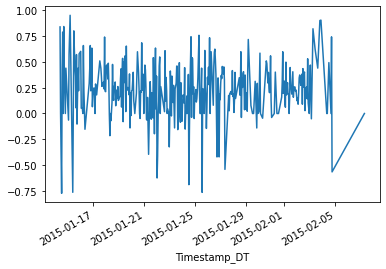

In [149]:
team_hourly_sentiment_train[0].plot()

<Axes: xlabel='Timestamp_DT'>

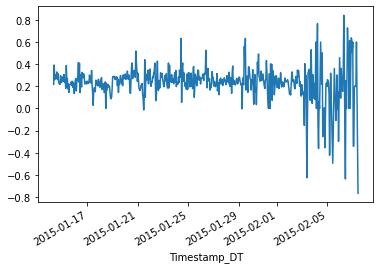

In [150]:
team_hourly_sentiment_train[1].plot()